In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
import pickle
import myUtils
import os
import matplotlib.pyplot as plt
from myUtils import *
from models.utils import *
from APOC import *
import sys
sys.path.append('models')

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch._C._jit_set_texpr_fuser_enabled(False)
model_name = 'huawei-noah/TinyBERT_General_4L_312D'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# can be sentiment/dilemma/corona
dataset_name = 'corona'
model_type = 'tinybert'
sorting = 'confidence'
delta = 0.1
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'

In [14]:
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = False)
myUtils.model = model
myUtils.tokenizer = tokenizer

In [15]:
explanations  = pickle.load(open(f"{folder_name}/exps_list.pickle", "rb" ))
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
print(f'anchor examples len: {len(anchor_examples)}')
print(f'explanations len: {len(explanations)}')

if not os.path.exists(f"{folder_name}/predictions.pickle"):
    predictions = [predict_sentences([tokenizer.tokenize(anchor_example)])[0] for anchor_example in anchor_examples]
    pickle.dump(predictions, open(f"{folder_name}/predictions.pickle", "wb" ))
    
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))

anchor examples len: 3449
explanations len: 68194


## Score Calculating

In [22]:
""" calculate avg / sum aggragation types """
ApocUtils.calculate_agg_score(folder_name, tokenizer, anchor_examples, explanations, labels, 'sum')

1028


In [27]:
num_exps = len(explanations)
for i in [10, 25, 50, 75, 100]:
    index = int((i*num_exps/100))
    exps = explanations[:index]
    ApocUtils.calculate_percent_scores(folder_name, tokenizer, anchor_examples, exps, labels, i)

353
961
1721
2210
2490


In [18]:
""" reverse!!! """
reverse_folder = f'results/{model_type}/{dataset_name}/{sorting}-reverse/{delta}'
num_exps = len(explanations)
for i in [10, 25, 50, 75, 100]:
    index = int((i*num_exps/100))
    exps = explanations[:index]
    ApocUtils.calculate_percent_scores(reverse_folder, tokenizer, anchor_examples[::-1], exps[::-1], labels[::-1], i)

328
707
1236
1623
1880


# APOC

## Corona

In [10]:
dataset_name = 'corona'
model_type = 'tinybert'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model

### Apoc

In [11]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, f"{dataset_name} {sorting} {delta}", num_removes=10)

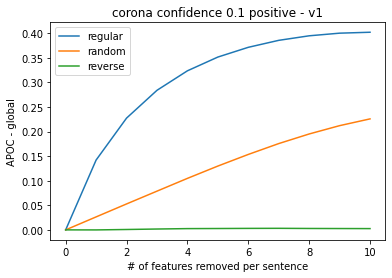

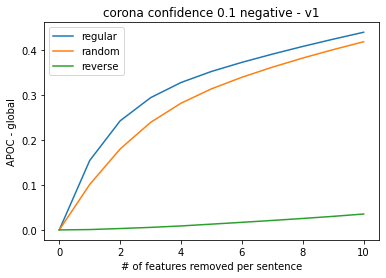

In [12]:
apoc.apoc_global('v1', 'remove')

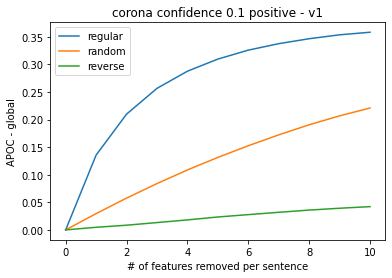

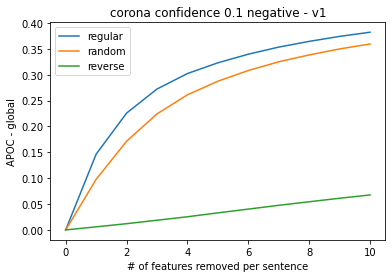

In [13]:
apoc.apoc_global('v1', 'replace')

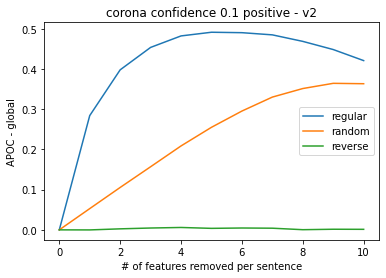

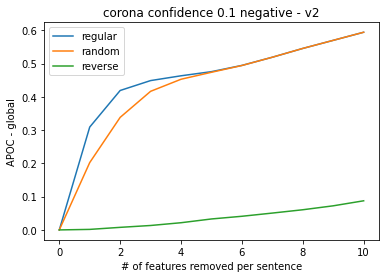

In [14]:
apoc.apoc_global('v2', 'remove')

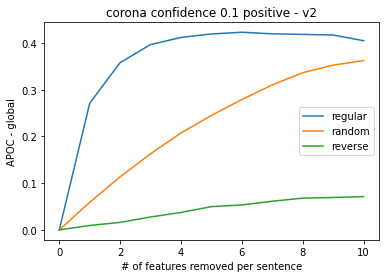

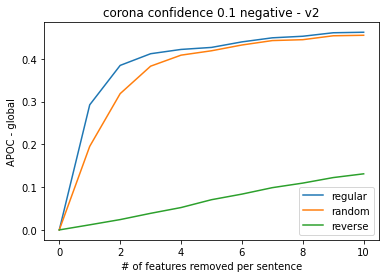

In [15]:
apoc.apoc_global('v2', 'replace')

### Compare

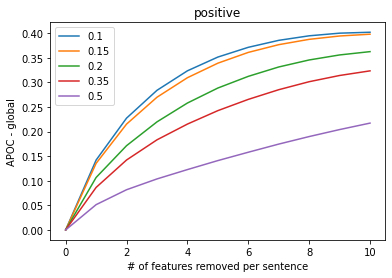

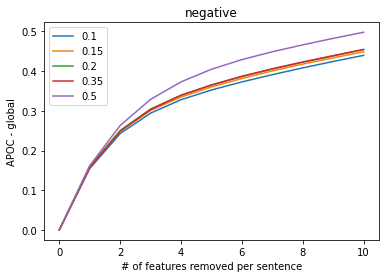

In [6]:
deltas = [0.1, 0.15, 0.2, 0.35, 0.5]
get_scores_fn = lambda delta: ApocUtils.get_scores_dict(folder_name, trail_path = f"../{delta}/scores.xlsx")
APOC.compare_apocs(model, tokenizer, deltas, get_scores_fn, anchor_examples, labels, deltas, num_removes = 10)

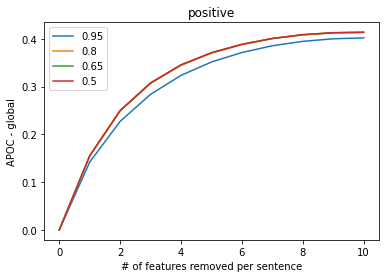

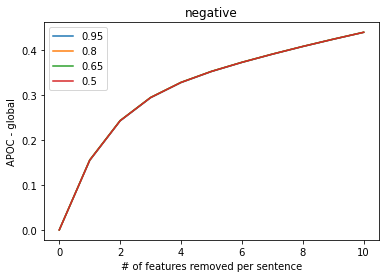

In [7]:
alphas = [0.95, 0.8, 0.65, 0.5]
get_scores_fn = lambda alpha: ApocUtils.get_scores_dict(folder_name, trail_path = "../0.1/scores.xlsx", alpha = alpha)
APOC.compare_apocs(model, tokenizer, alphas, get_scores_fn, anchor_examples, labels, alphas, num_removes = 10)

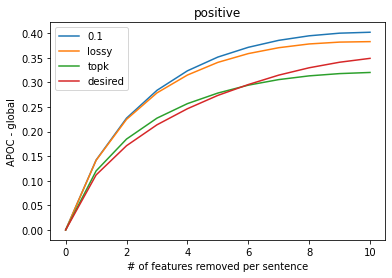

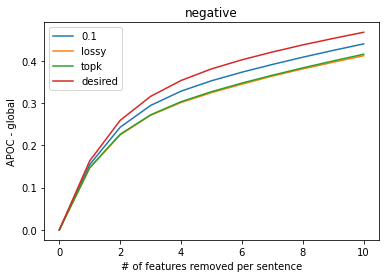

In [8]:
optimizations = [str(0.1), 'lossy', 'topk', 'desired']
get_scores_fn = lambda optimization: ApocUtils.get_scores_dict(folder_name, trail_path = f"../{optimization}/scores.xlsx")
APOC.compare_apocs(model, tokenizer, optimizations, get_scores_fn, anchor_examples, labels, optimizations, num_removes = 10)

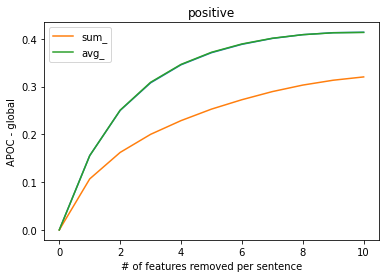

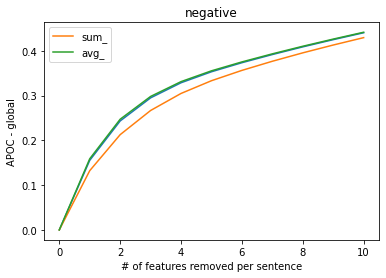

In [20]:
aggragations = ['', 'sum_', 'avg_']
alphas = [0.5, None, None]
get_scores_fn = lambda x: ApocUtils.get_scores_dict(folder_name, folder_name, trail_path = f"../0.1/{x[0]}scores.xlsx", alpha = x[1])
APOC.compare_apocs(model, tokenizer, zip(aggragations, alphas), get_scores_fn, anchor_examples, labels, aggragations, num_removes = 10)

#### polarity

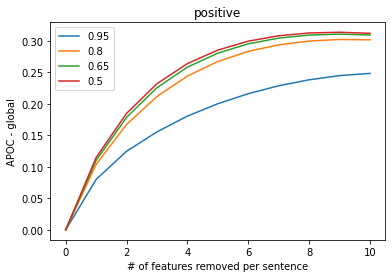

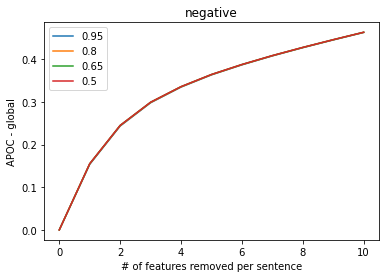

In [21]:
"""polarity"""
alphas = [0.95, 0.8, 0.65, 0.5, 0.4, 0.3]
get_scores_fn = lambda delta: ApocUtils.get_scores_dict(folder_name, trail_path = "../0.1/scores.xlsx", alpha = alpha)
APOC.compare_apocs(model, tokenizer, deltas, get_scores_fn, anchor_examples, labels, alphas, num_removes = 10)

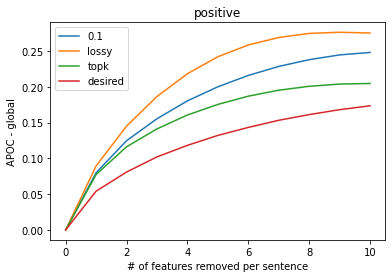

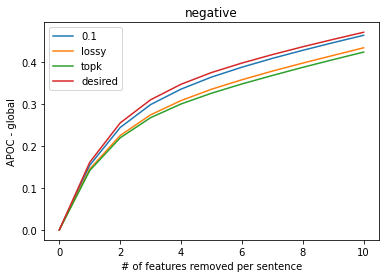

In [42]:
""" polarity """
optimizations = [str(0.1), 'lossy', 'topk', 'desired']
get_scores_fn = lambda delta: ApocUtils.get_scores_dict(folder_name, trail_path = f"../{optimization}/scores.xlsx")
APOC.compare_apocs(model, tokenizer, deltas, get_scores_fn, anchor_examples, labels, optimizations, num_removes = 10)

## Dilemma

In [ ]:
dataset_name = 'dilemma'
model_type = 'tinybert'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model

### Apoc

In [ ]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, f"{dataset_name} {sorting} {delta}", num_removes=10)

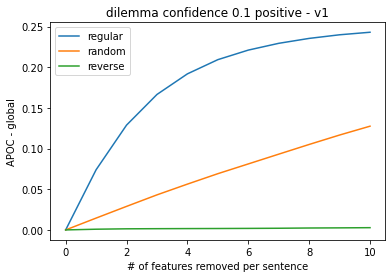

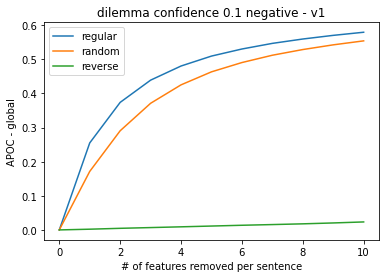

In [13]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

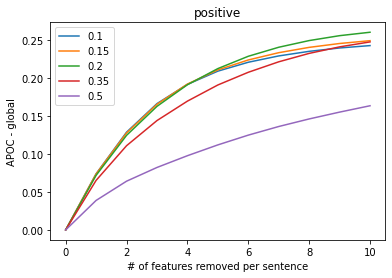

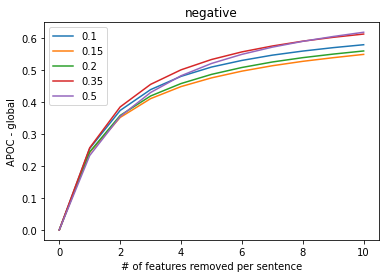

In [14]:
deltas = [0.1, 0.15, 0.2, 0.35, 0.5]
get_scores_fn = lambda delta: ApocUtils.get_scores_dict(folder_name, trail_path = f"../{delta}/scores.xlsx")
APOC.compare_apocs(model, tokenizer, deltas, get_scores_fn, anchor_examples, labels, deltas, num_removes = 10)

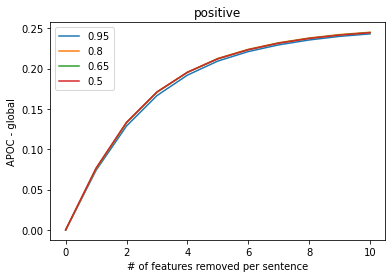

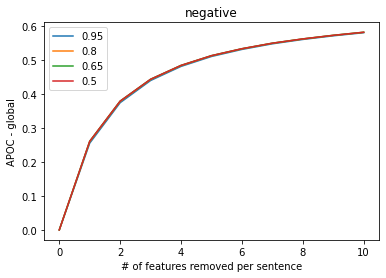

In [16]:
alphas = [0.95, 0.8, 0.65, 0.5, 0.4, 0.3]
get_scores_fn = lambda alpha: ApocUtils.get_scores_dict(folder_name, trail_path = "../0.1/scores.xlsx", alpha = alpha)
APOC.compare_apocs(model, tokenizer, alphas, get_scores_fn, anchor_examples, labels, alphas, num_removes = 10)

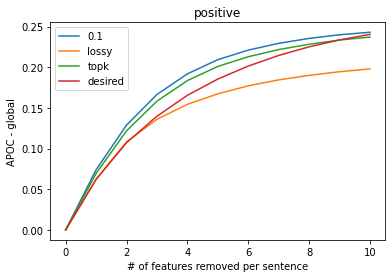

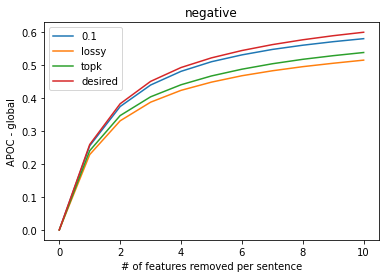

In [17]:
optimizations = [str(0.1), 'lossy', 'topk', 'desired']
get_scores_fn = lambda optimization: ApocUtils.get_scores_dict(folder_name, trail_path = f"../{optimization}/scores.xlsx")
APOC.compare_apocs(model, tokenizer, optimizations, get_scores_fn, anchor_examples, labels, optimizations, num_removes = 10)

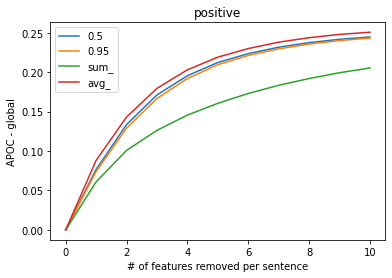

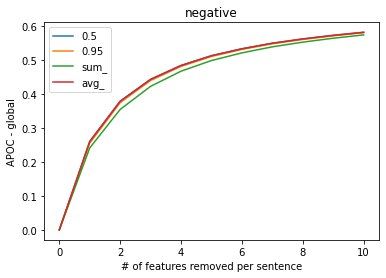

In [20]:
aggragations = ['', '', 'sum_', 'avg_']
alphas = [0.5, 0.95, None, None]
legends = [0.5, 0.95, 'sum', 'avg']
get_scores_fn = lambda x: ApocUtils.get_scores_dict(folder_name, folder_name, trail_path = f"../0.1/{x[0]}scores.xlsx", alpha = x[1])
APOC.compare_apocs(model, tokenizer, zip(aggragations, alphas), get_scores_fn, anchor_examples, labels, legends, num_removes = 10)

## GRU

In [9]:
dataset_name = 'corona'
model_type = 'gru'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model

### Apoc

In [11]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, f"{dataset_name} {sorting} {delta}", num_removes=10)

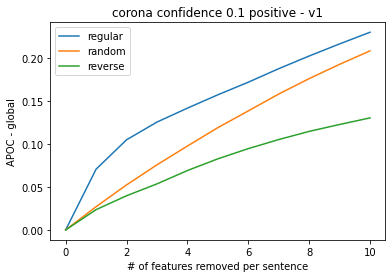

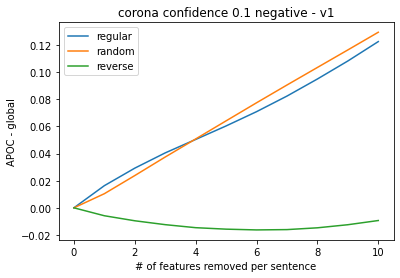

In [12]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

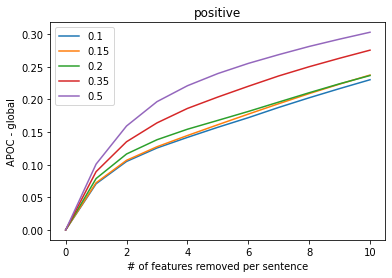

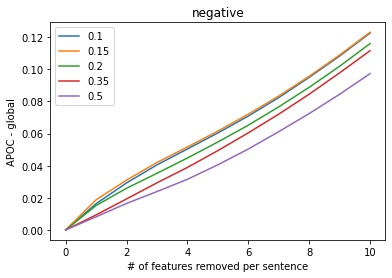

In [13]:
deltas = [0.1, 0.15, 0.2, 0.35, 0.5]
get_scores_fn = lambda delta: ApocUtils.get_scores_dict(folder_name, trail_path = f"../{delta}/scores.xlsx")
APOC.compare_apocs(model, tokenizer, deltas, get_scores_fn, anchor_examples, labels, deltas, num_removes = 10)

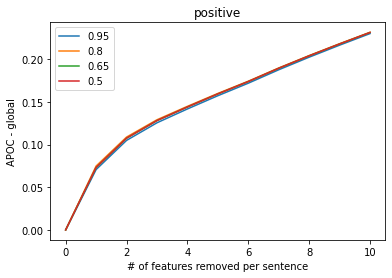

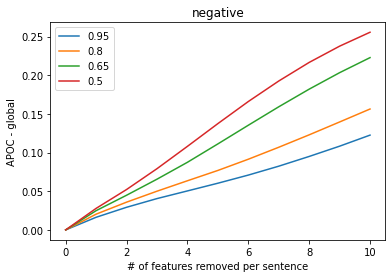

In [15]:
alphas = [0.95, 0.8, 0.65, 0.5]
get_scores_fn = lambda alpha: ApocUtils.get_scores_dict(folder_name, trail_path = "../0.1/scores.xlsx", alpha = alpha)
APOC.compare_apocs(model, tokenizer, alphas, get_scores_fn, anchor_examples, labels, alphas, num_removes = 10)

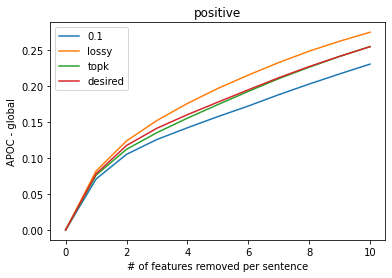

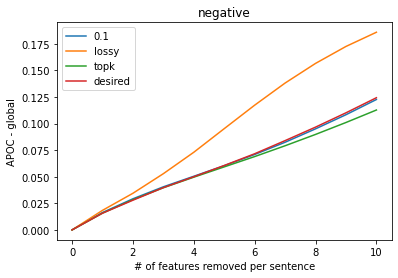

In [16]:
optimizations = [str(0.1), 'lossy', 'topk', 'desired']
get_scores_fn = lambda optimization: ApocUtils.get_scores_dict(folder_name, trail_path = f"../{optimization}/scores.xlsx")
APOC.compare_apocs(model, tokenizer, optimizations, get_scores_fn, anchor_examples, labels, optimizations, num_removes = 10)

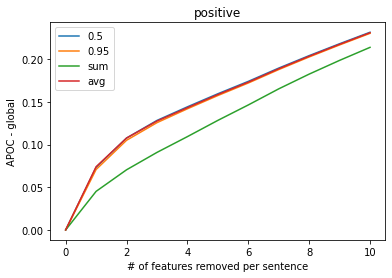

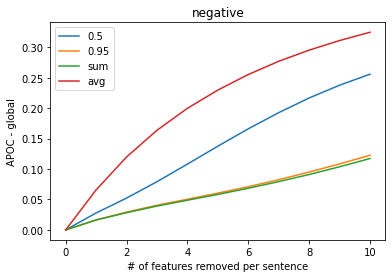

In [17]:
aggragations = ['', '', 'sum_', 'avg_']
alphas = [0.5, 0.95, None, None]
legends = [0.5, 0.95, 'sum', 'avg']
get_scores_fn = lambda x: ApocUtils.get_scores_dict(folder_name, folder_name, trail_path = f"../0.1/{x[0]}scores.xlsx", alpha = x[1])
APOC.compare_apocs(model, tokenizer, zip(aggragations, alphas), get_scores_fn, anchor_examples, labels, legends, num_removes = 10)

# APOC MODIFIED

params: modefied = True, num_removes = 25

## Corona

In [19]:
dataset_name = 'corona'
model_type = 'tinybert'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [6]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, title, modified = True, num_removes = 25)

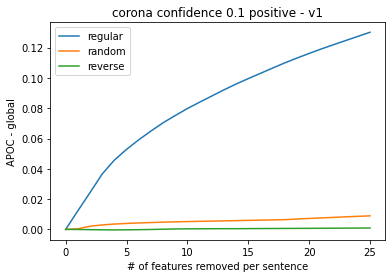

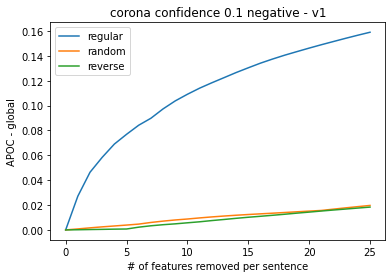

In [9]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

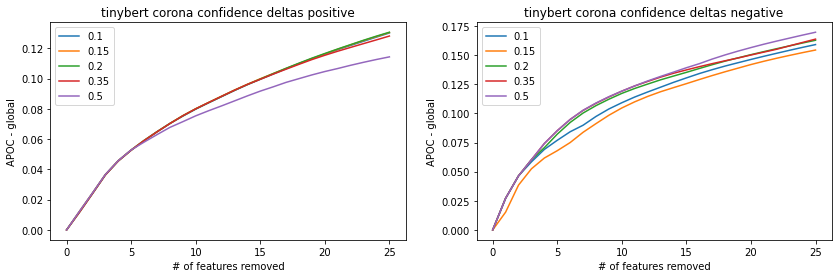

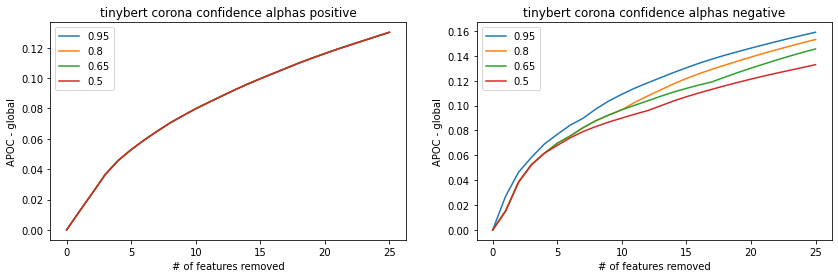

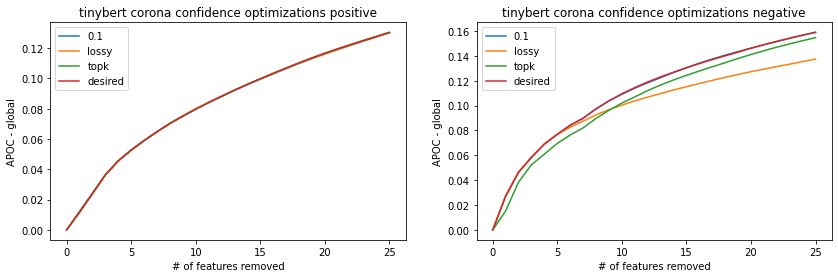

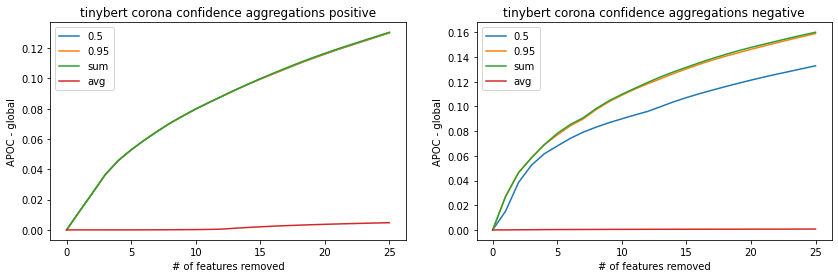

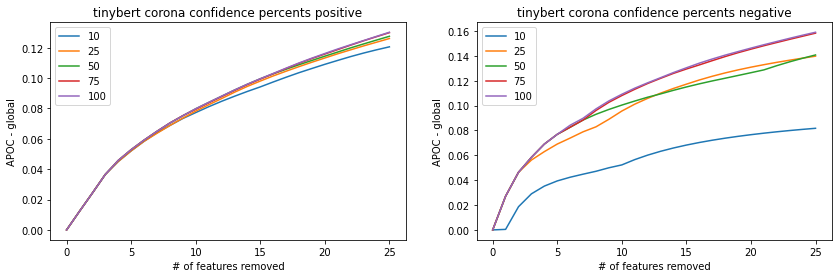

In [7]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)

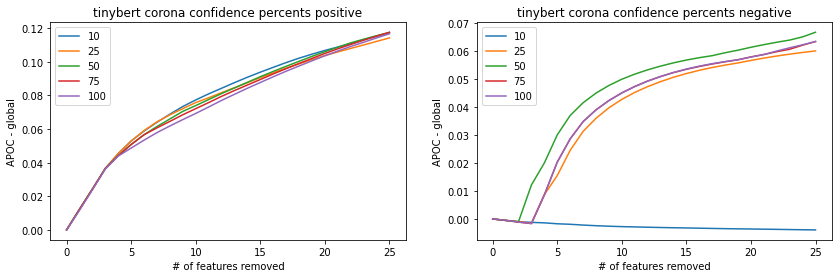

In [23]:
reverse_folder = f'results/{model_type}/{dataset_name}/{sorting}-reverse/{delta}'
percents = [10, 25, 50, 75, 100]
get_scores_fn = lambda percent: ApocUtils.get_scores_dict(reverse_folder, trail_path = f"../0.1/time/scores-{percent}.xlsx", alpha = 0.95)
APOC.compare_apocs(model, tokenizer, percents, get_scores_fn, anchor_examples[::-1], labels[::-1], percents, f'{title} percents', num_removes=25, modified=True)

## Dilemma

In [4]:
dataset_name = 'dilemma'
model_type = 'tinybert'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [ ]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, title, modified = True, num_removes = 25)

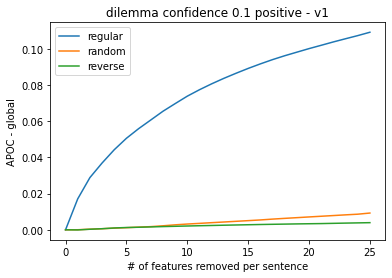

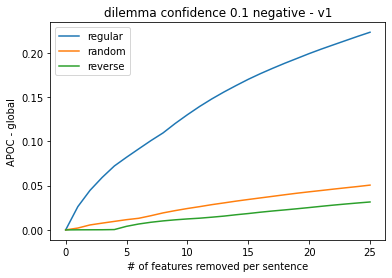

In [10]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

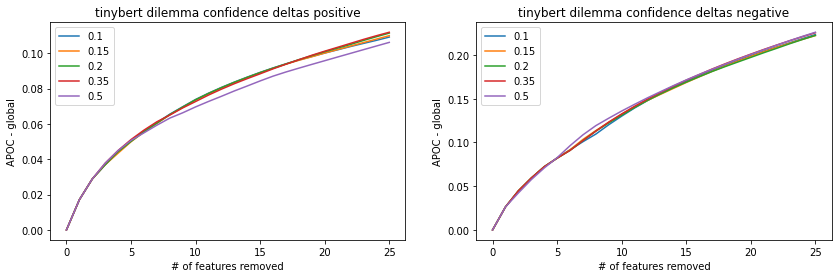

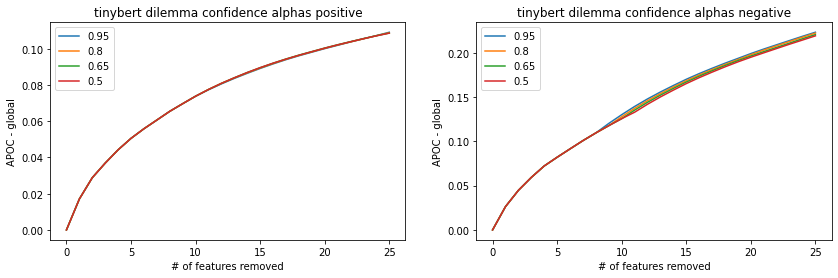

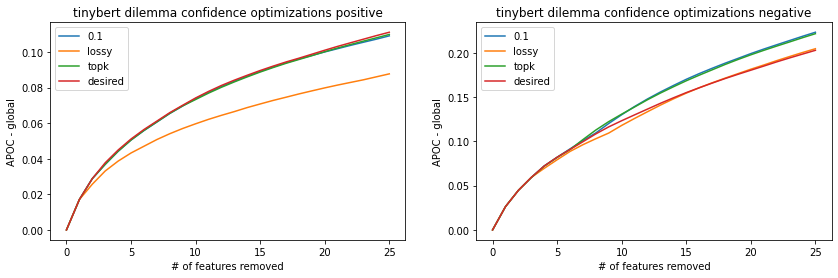

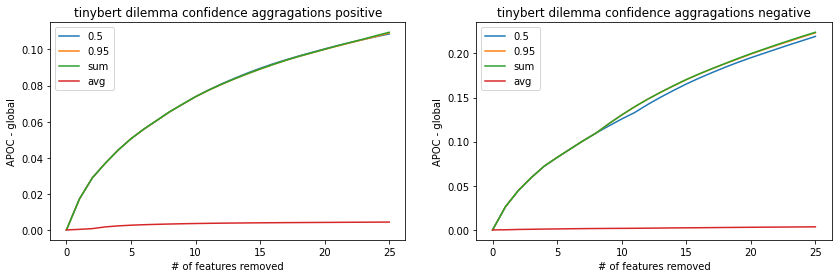

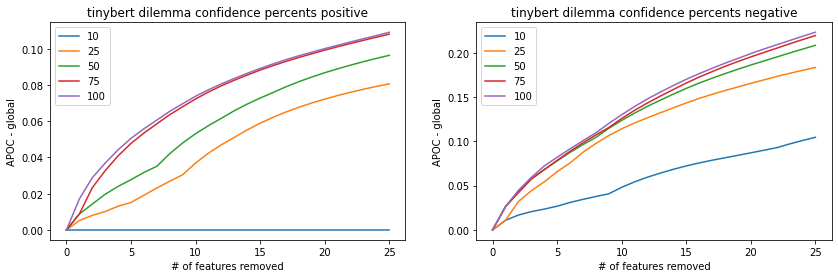

In [8]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)

## Sentiment

In [10]:
dataset_name = 'sentiment'
model_type = 'tinybert'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [7]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, title, modified = True, num_removes = 25)

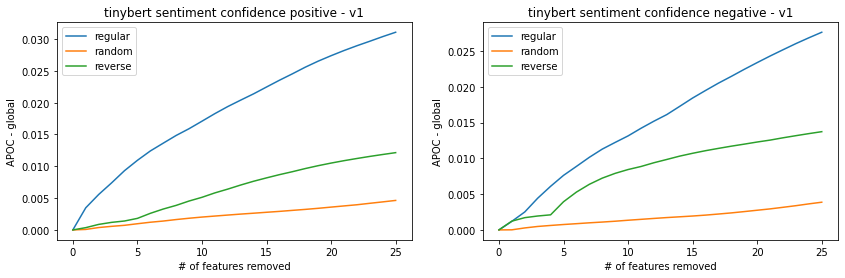

In [11]:
""" lossy apoc """
lossy_folder = f'results/{model_type}/{dataset_name}/{sorting}/lossy'
pos_scores, neg_scores = ApocUtils.get_scores_dict(lossy_folder, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, title, modified = True, num_removes = 25)
apoc.apoc_global('v1', 'remove')

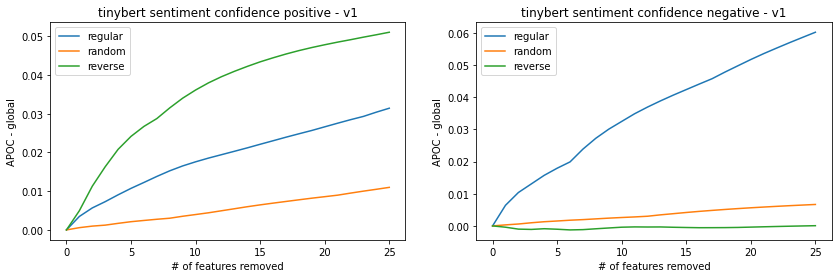

In [13]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

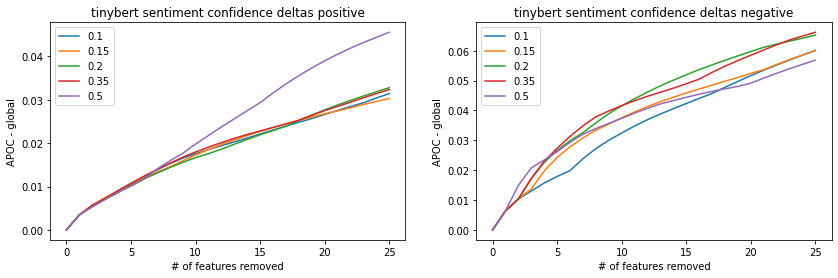

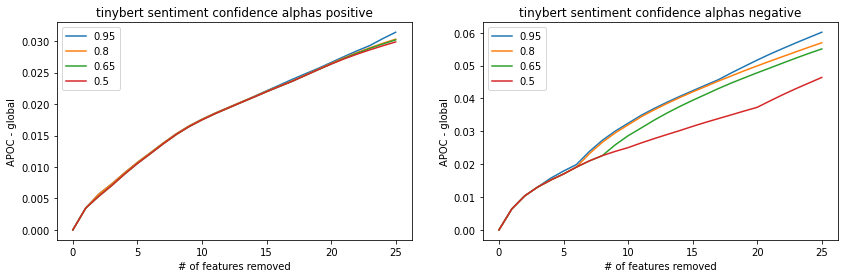

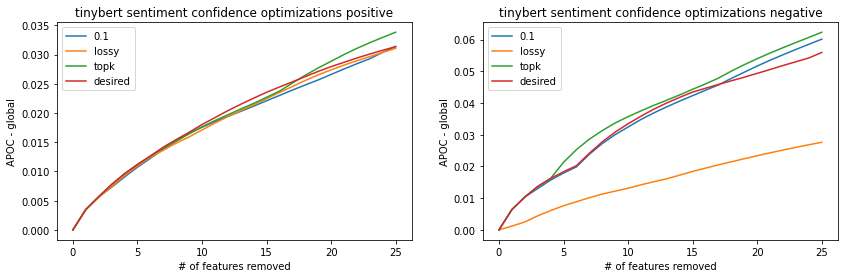

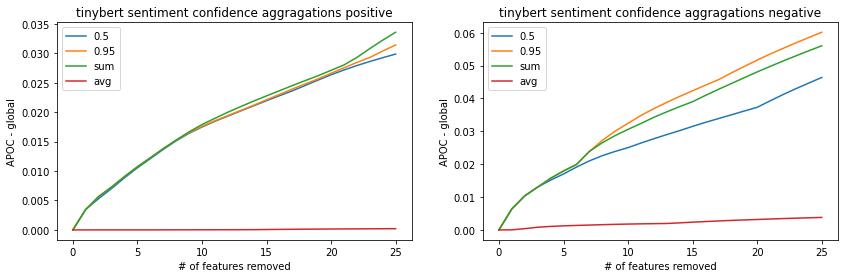

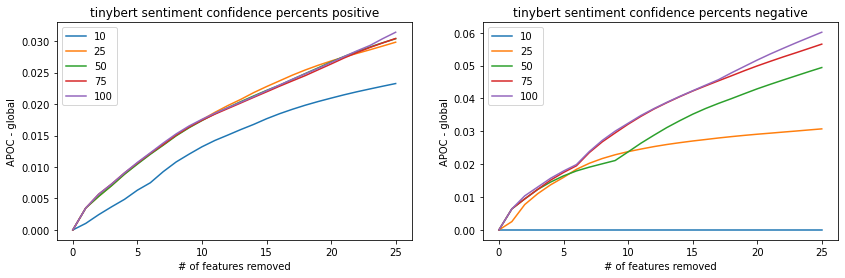

In [15]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)

## GRU Corona

In [29]:
dataset_name = 'corona'
model_type = 'gru'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [19]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, f"{dataset_name} {sorting} {delta}", modified = True, num_removes = 25)

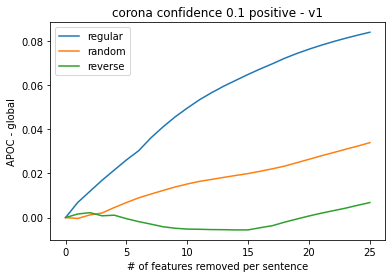

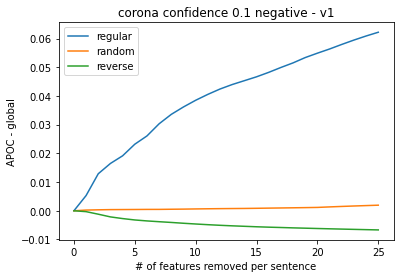

In [20]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

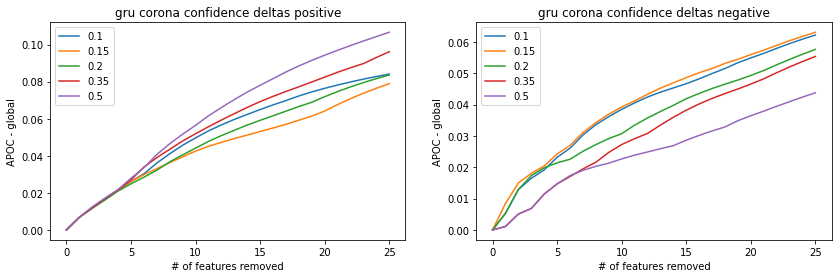

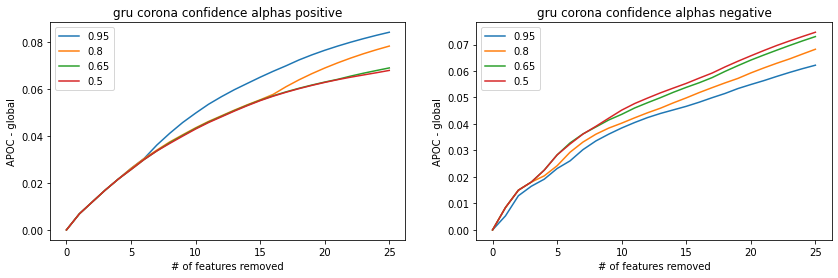

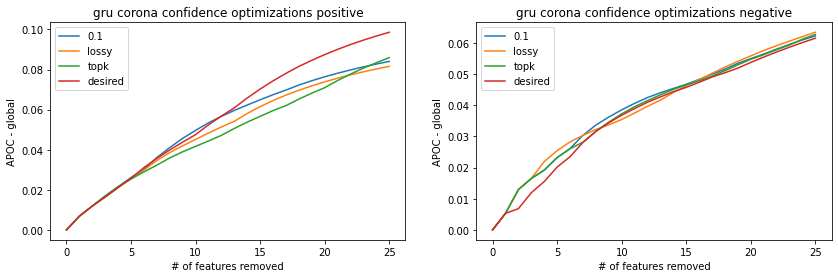

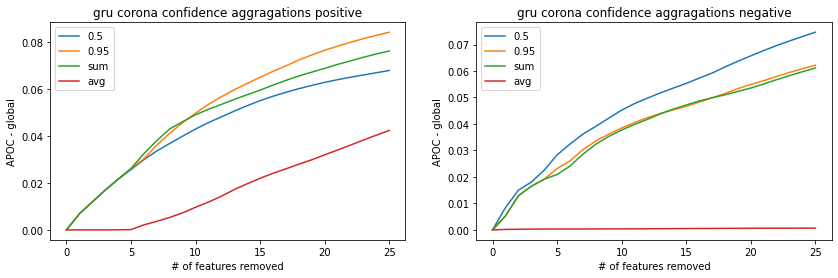

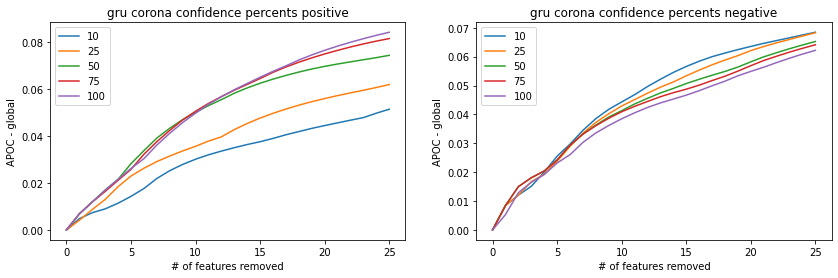

In [23]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)

## GRU Sentiment

In [71]:
dataset_name = 'sentiment'
model_type = 'gru'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [18]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, f"{dataset_name} {sorting} {delta}", modified = True, num_removes = 25)

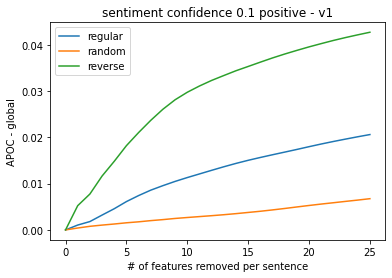

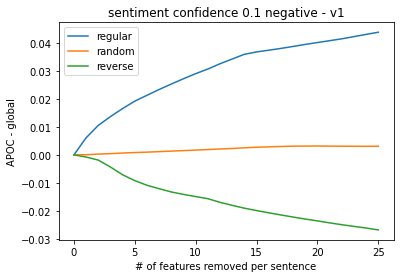

In [19]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

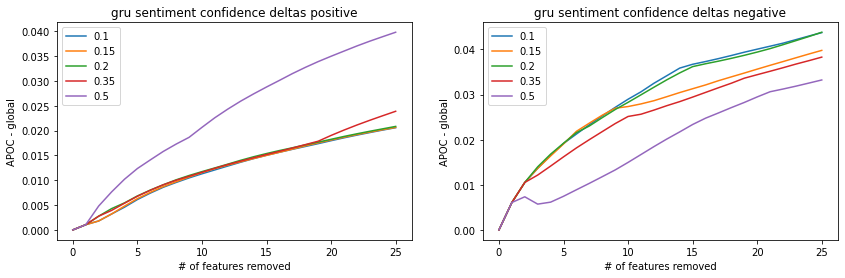

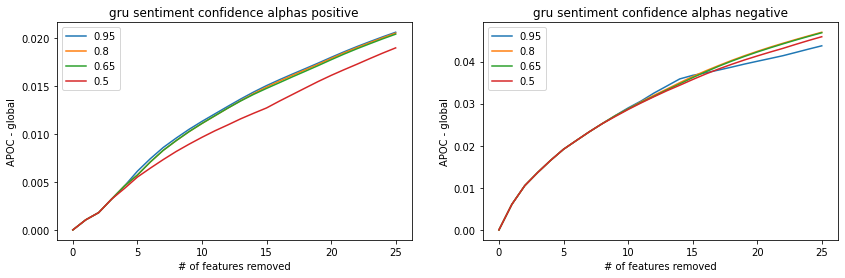

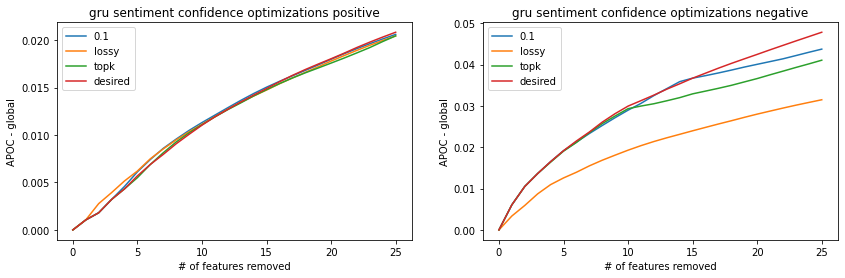

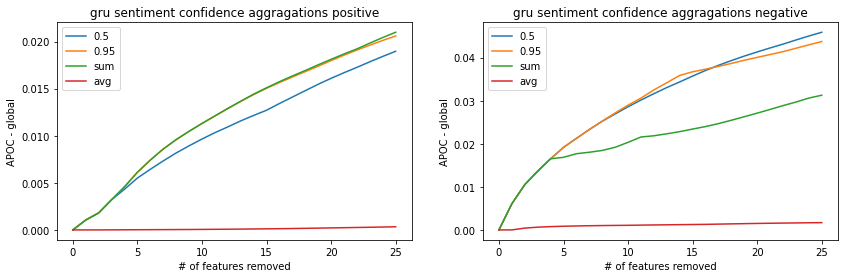

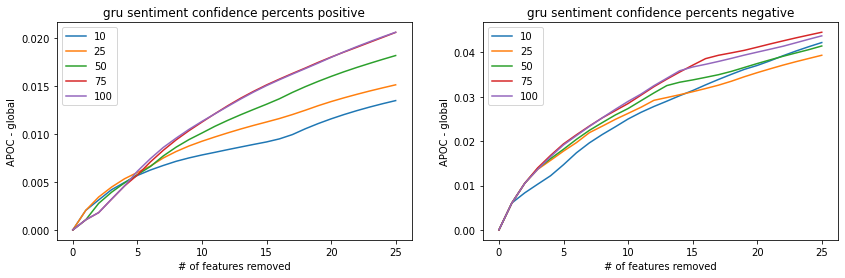

In [72]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)

## SVM Corona

In [73]:
dataset_name = 'corona'
model_type = 'svm'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [27]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, f"{dataset_name} {sorting} {delta}", modified = True, num_removes = 25)

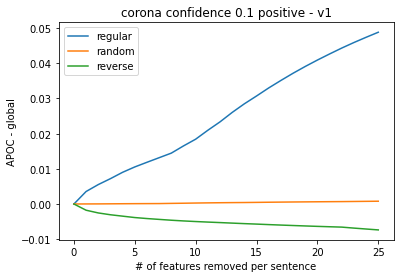

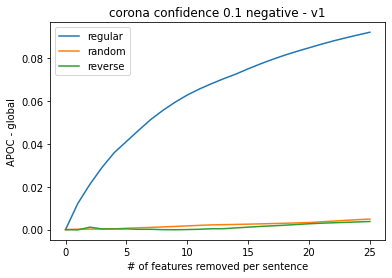

In [28]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

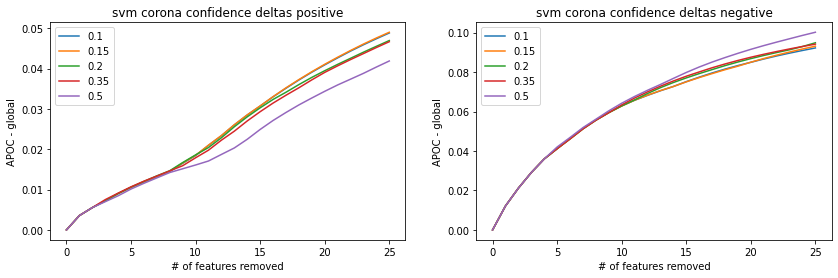

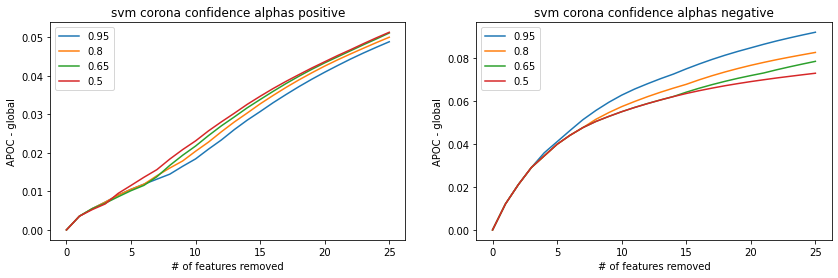

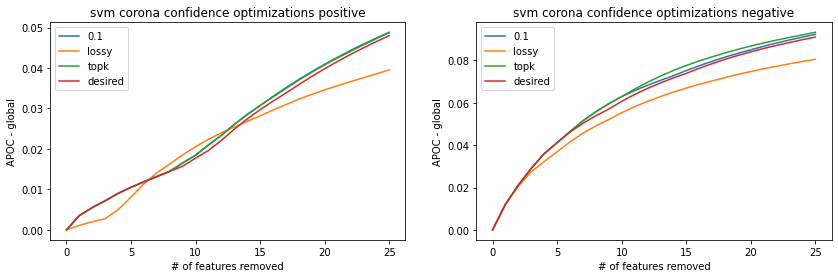

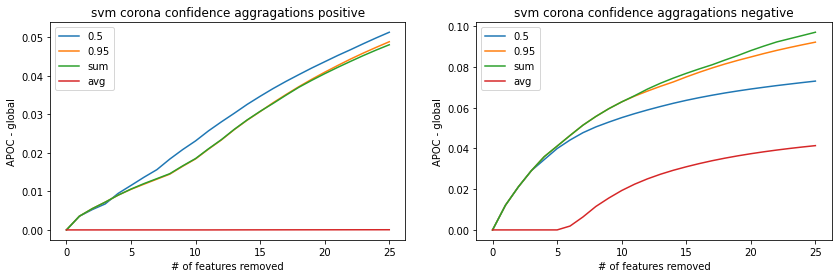

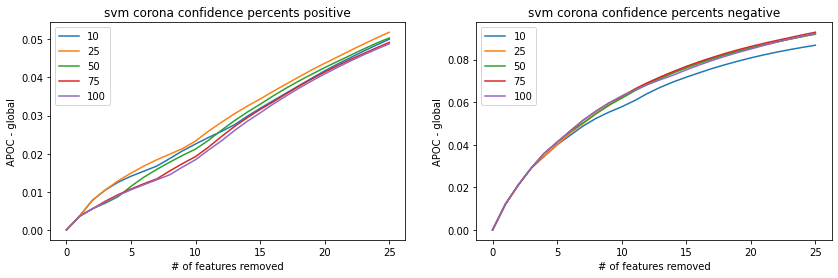

In [74]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)

## SVM Sentiment

In [75]:
dataset_name = 'sentiment'
model_type = 'svm'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [43]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, f"{dataset_name} {sorting} {delta}", modified = True, num_removes = 25)

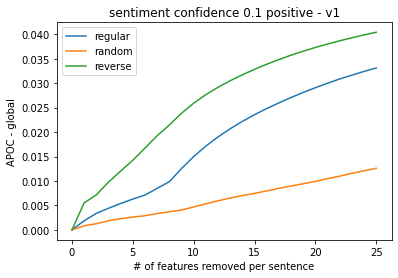

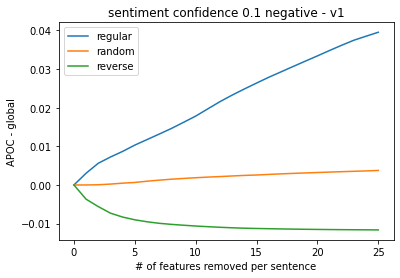

In [44]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

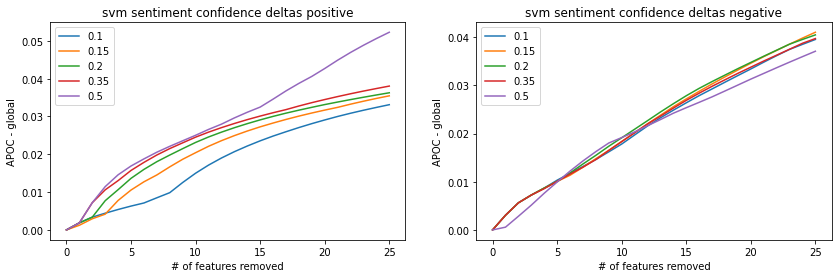

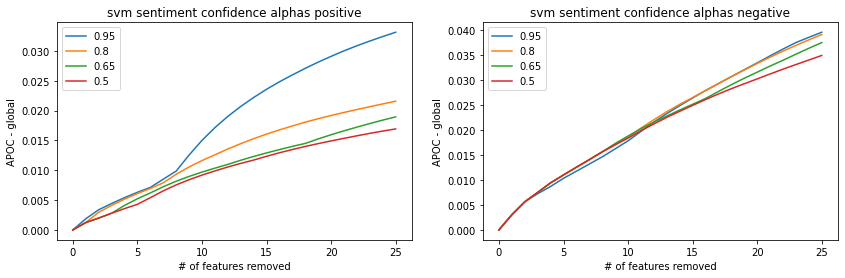

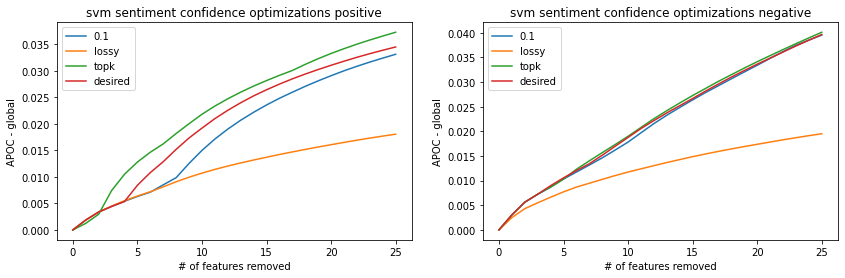

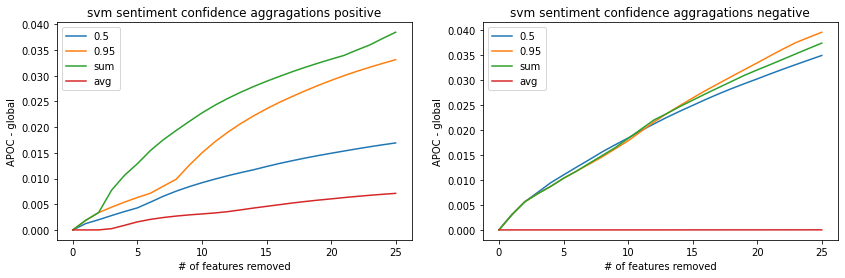

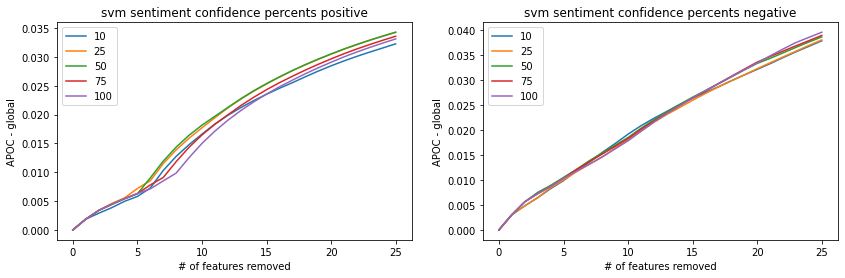

In [76]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)

## SVM Dilemma

In [8]:
dataset_name = 'dilemma'
model_type = 'svm'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [51]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, f"{dataset_name} {sorting} {delta}", modified = True, num_removes = 25)

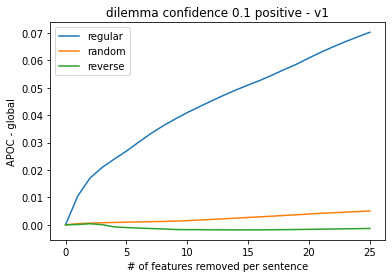

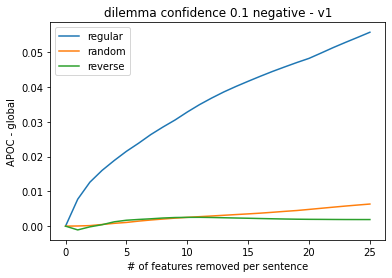

In [52]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

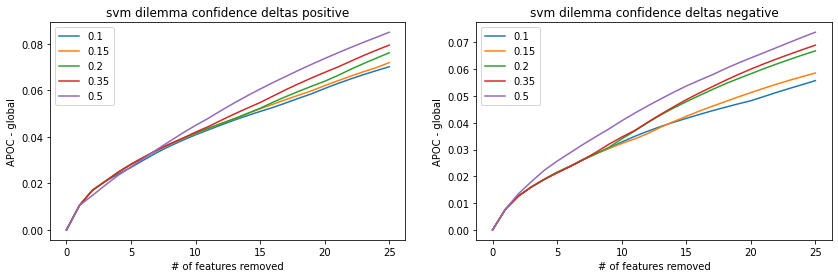

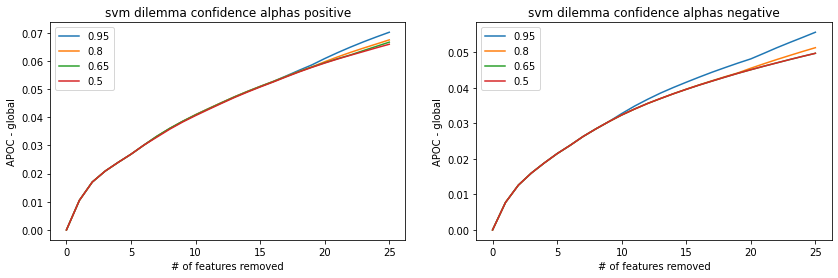

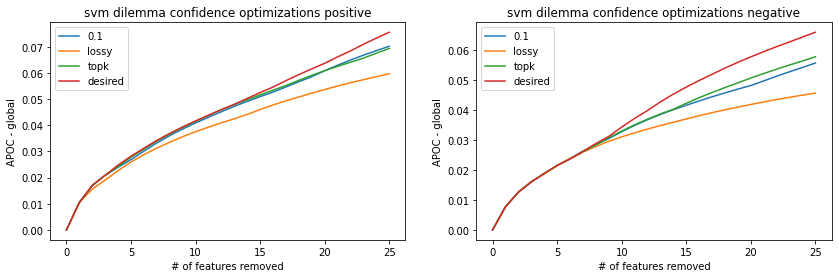

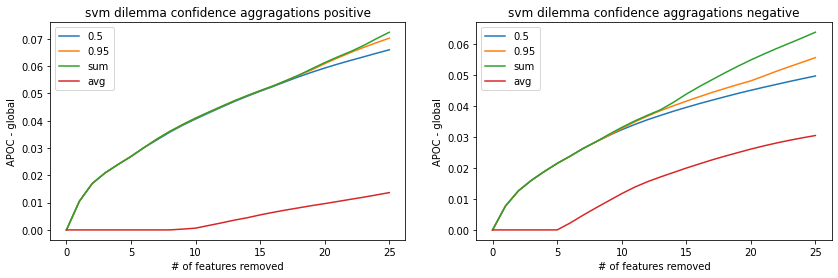

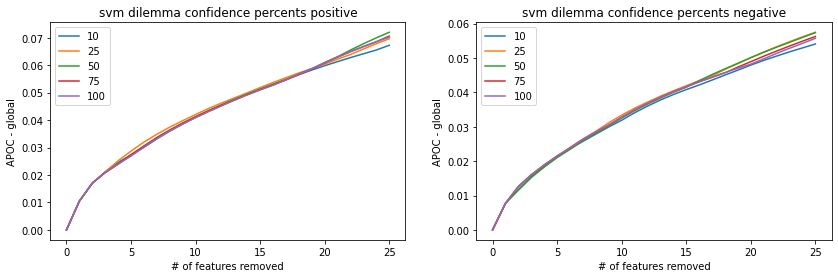

In [78]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)

## Logistic Corona

In [12]:
dataset_name = 'corona'
model_type = 'logistic'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [9]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, title, modified = True, num_removes = 25)

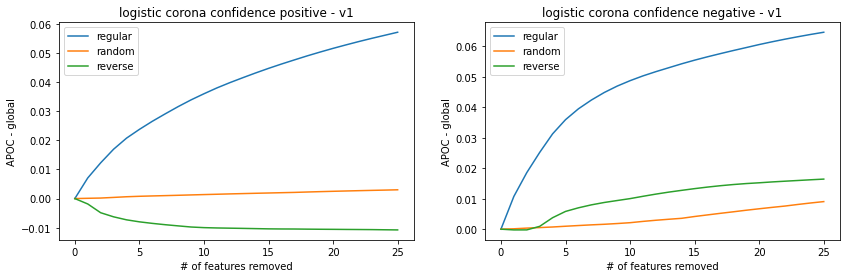

In [10]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

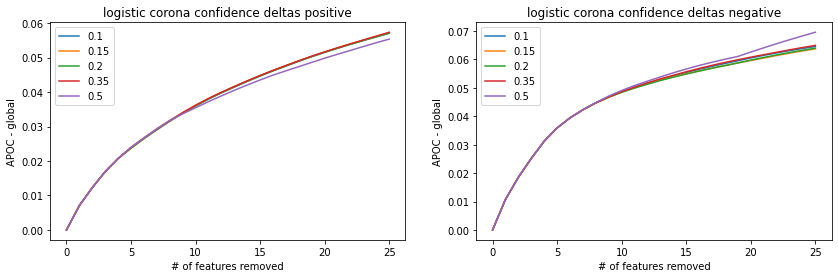

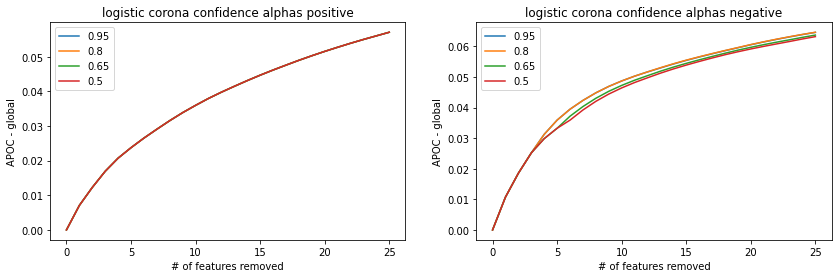

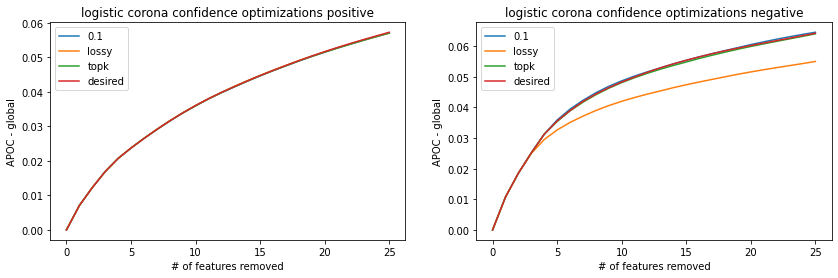

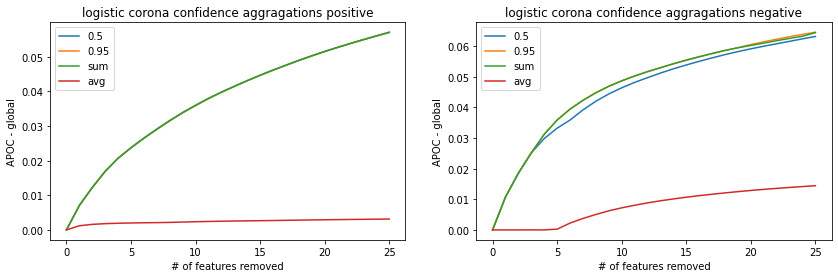

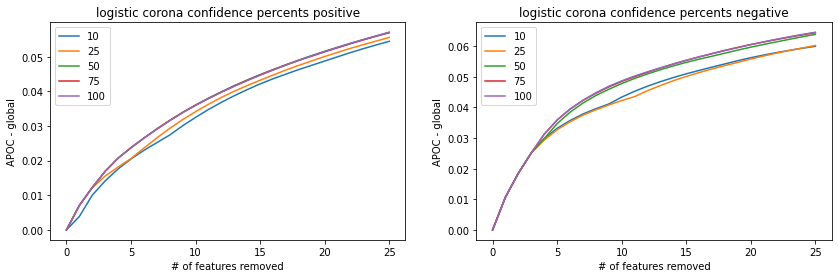

In [13]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)

## Logistic Dilemma

In [22]:
dataset_name = 'dilemma'
model_type = 'logistic'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [15]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, title, modified = True, num_removes = 25)

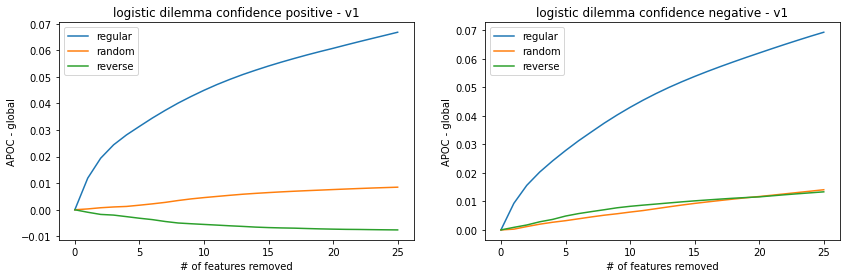

In [16]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

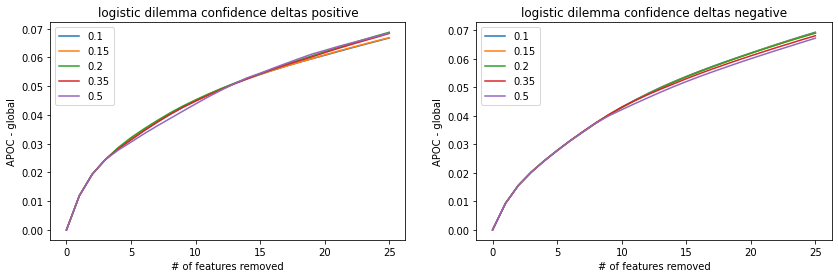

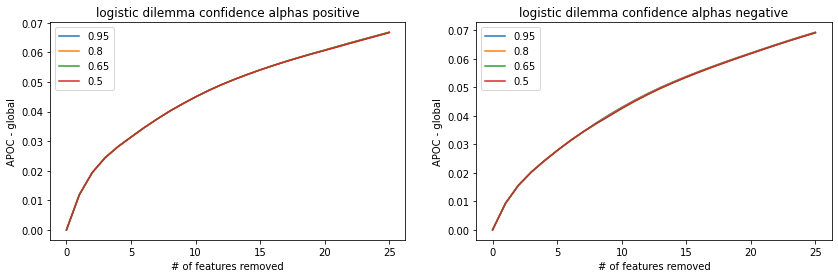

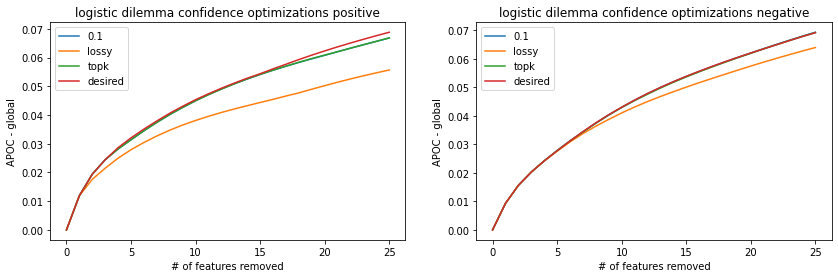

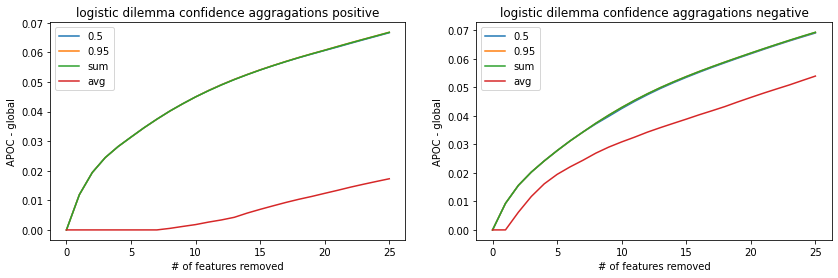

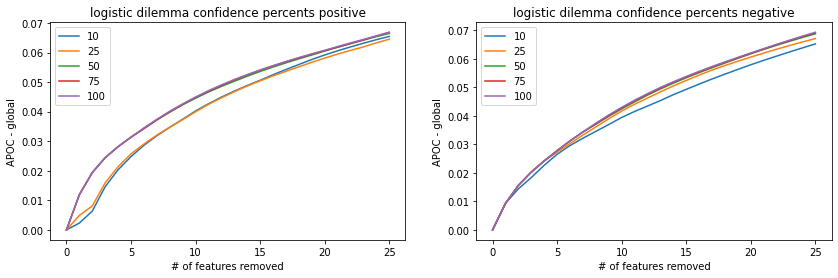

In [23]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)

## Logistic Sentiment

In [4]:
dataset_name = 'sentiment'
model_type = 'logistic'
folder_name = f'results/{model_type}/{dataset_name}/{sorting}/{delta}'
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))
model = load_model(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
myUtils.model = model
title = f"{model_type} {dataset_name} {sorting}"

### Apoc

In [25]:
pos_scores, neg_scores = ApocUtils.get_scores_dict(folder_name, trail_path = "scores.xlsx")
pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
apoc = APOC(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, title, modified = True, num_removes = 25)

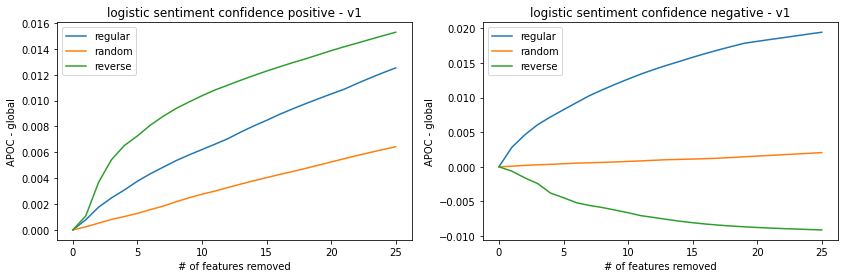

In [26]:
apoc.apoc_global('v1', 'remove')

In [ ]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

### Compare

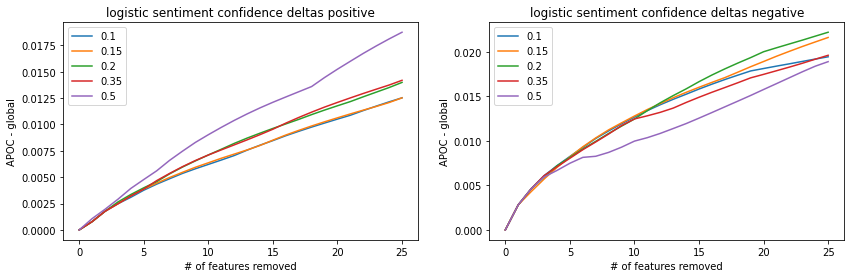

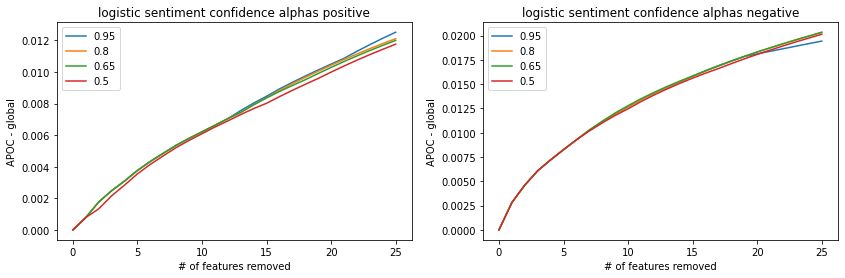

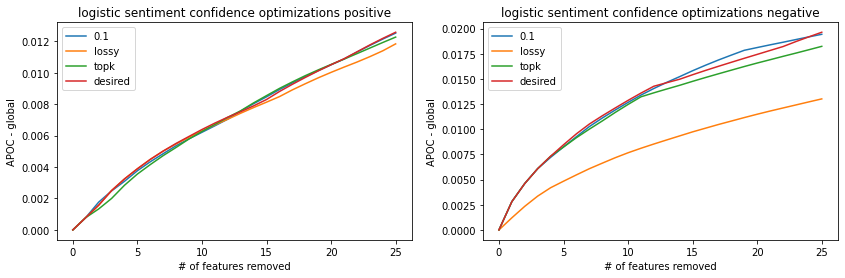

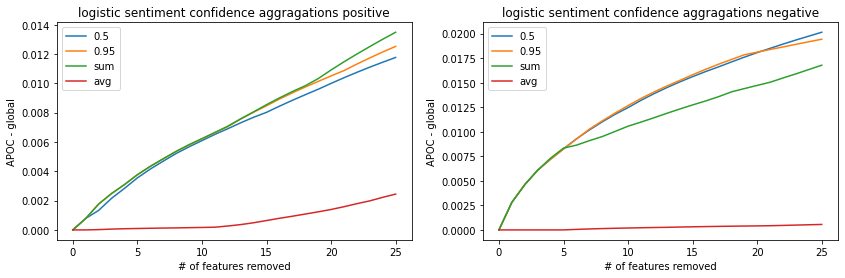

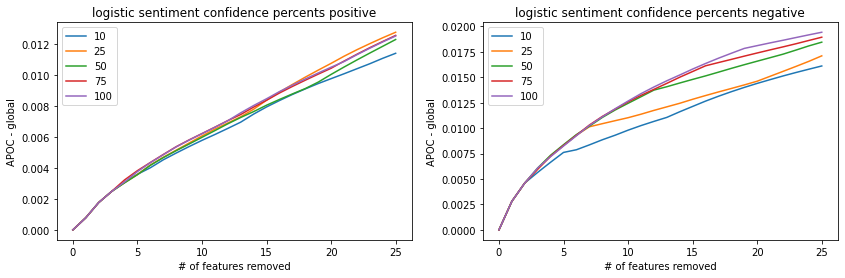

In [5]:
APOC.compare_all(folder_name, model, tokenizer, anchor_examples, labels, title, modified = True, num_removes = 25)